In [135]:
import pandas as pd
from sqlalchemy import create_engine
import os
import requests
from bs4 import BeautifulSoup
from datetime import date
import matplotlib.pyplot as plt
import numpy as np

In [29]:
#IMPORT TABLES FROM THE DATABASE

sqlitedb_path = 'data/raw/raw_data_project_m1.db'
engine = create_engine(f'sqlite:///{sqlitedb_path}')

df_raw =pd.read_sql_query("""
SELECT personal_info.uuid, age, gender, dem_has_children, age_group AS "Age Group", dem_education_level, dem_full_time_job, normalized_job_code as "Normalized Job Code", country_code as "Country code", rural, question_bbi_2016wave4_basicincome_awareness AS "question: BI awareness", question_bbi_2016wave4_basicincome_effect AS "question: BI effect",question_bbi_2016wave4_basicincome_argumentsfor AS "question: BI arguments for",question_bbi_2016wave4_basicincome_argumentsagainst AS "question: BI arguments against" 
FROM personal_info
LEFT JOIN career_info ON personal_info.uuid = career_info.uuid
LEFT JOIN country_info ON personal_info.uuid = country_info.uuid
LEFT JOIN poll_info ON personal_info.uuid = poll_info.uuid
""", engine)

df_raw.to_csv(f'data/raw/historical_data/{date.today()}-data.csv',index=False)

In [176]:
selected_columns = ["uuid", "age","Age Group","gender","Country code","Normalized Job Code"]
df_good = df_raw[selected_columns]


In [177]:
sorted(df_good["Age Group"].unique())

['14_25', '26_39', '40_65', 'juvenile']

In [174]:
sorted(df_good["gender"].unique())

['Female', 'Male']

In [173]:
#DATA CLEANING

df_good["age"].replace('\s\w*\s\w*',"",regex=True, inplace = True)
df_good["age"] = df_good["age"].apply(lambda x: 2016-int(x) if len(x)>2 else x)
df_good['Normalized Job Code'].fillna('no_full_time_job',inplace=True)
df_good["gender"].replace(to_replace = ['male','Fem','FeMale','female'], value = ['Male', 'Female','Female','Female'],inplace=True) 
df_good["Age Group"].replace(to_replace = ['juvenile'], value = ['14_25'],inplace=True) 
df_good["Age Group"].replace(to_replace = ['40_65', '26_39', '14_25'], value = ['40 to 65 years', '26 to 39 years', '14 to 25 years'],inplace=True)




/Users/ignaciosanchezjurado/miniconda3/envs/ironhack_env/lib/python3.7/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/ignaciosanchezjurado/miniconda3/envs/ironhack_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ignaciosanchezjurado/miniconda3/envs/ironhack_env/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [33]:
df_bonus2 = df_raw["dem_education_level"]

In [34]:
df_raw["dem_education_level"].unique()

array(['no', 'high', None, 'medium', 'low'], dtype=object)

In [138]:
url = 'https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Country_codes'
html = requests.get(url).content
soup = BeautifulSoup(html, 'lxml')

countries2 = soup.find_all('td')
testing2 = list(filter(None,[i.text.strip().replace('\n','').replace('(','').replace(')','') for i in countries2]))
countries_refactored2 = [testing2[x:x+2] for x in range(0, len(testing2), 2)]

AttributeError: 'list' object has no attribute 'dropna'

In [ ]:
testing3 = [i.text.strip().replace('\n','').replace('(','').replace(')','') for i in countries2]


In [ ]:
list(filter(lambda x: x < 0, number_list))

In [35]:
# PAISES
url = 'https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Country_codes'
html = requests.get(url).content
soup = BeautifulSoup(html, 'lxml')

countries = soup.find_all('td')
lista=[i.text for i in countries]

list_countries=[i.strip().replace('\n','').replace('(','').replace(')','') for i in lista if len(i)>3]
countries_parsed = [row for row in list_countries]
row_split=2
countries_refactored = [countries_parsed[x:x+row_split] for x in range(0, len(countries_parsed), row_split)]

#DATA CLEANING
df_countries=pd.DataFrame(countries_refactored,columns=["Country","Country code"])
df_countries.replace(to_replace=["EL","UK"],value=["GR","GB"],inplace=True)

In [27]:
#/Users/ignaciosanchezjurado/Documents/dataparttime/ih_datamadpt0420_project_m1/data/raw/historical_data

guarda copia csv y lugo limpiez (wrangling)

In [158]:
#CONECTAR API
'''
unique_jobcodes = df_good["Normalized Job Code"].unique()[1:]
job_names = []
for job in unique_jobcodes:
    response = requests.get('http://api.dataatwork.org/v1/jobs/'+job)
    job_names.append(response.json())
df_jobnames = pd.DataFrame(job_names).rename(columns={'uuid':'Normalized Job Code','title':'Job Title'})
'''

In [167]:
#CONECTAR API - Refactorizado

unique_jobcodes = df_good["Normalized Job Code"].unique()[1:]
job_names = [requests.get('http://api.dataatwork.org/v1/jobs/'+job).json() for job in unique_jobcodes]
df_jobnames = pd.DataFrame(job_names2).rename(columns={'uuid':'Normalized Job Code','title':'Job Title'})


In [39]:
#MERGE TODOS LOS DF
df_first_merge=pd.merge(df_good,df_countries,on="Country code",how="inner")
df_merged=pd.merge(df_first_merge,df_jobnames,on="Normalized Job Code")

In [153]:
df_merged.head()

,uuid,age,Age Group,gender,Country code,Normalized Job Code,Country,normalized_job_title,parent_uuid,Job Title
0,54f0f1c0-dda1-0133-a559-0a81e8b09a82,57,40 to 65 years,Male,AT,861a9b9151e11362eb3c77ca914172d0,Austria,automatic data processing planner,0148f61d4227497728ce33490843d056,Automatic Data Processing Planner
1,cf24ed60-da3f-0133-0034-0a81e8b09a82,48,40 to 65 years,Female,AT,861a9b9151e11362eb3c77ca914172d0,Austria,automatic data processing planner,0148f61d4227497728ce33490843d056,Automatic Data Processing Planner
2,9ffc7390-dba5-0133-259b-0a81e8b09a82,43,40 to 65 years,Male,BE,861a9b9151e11362eb3c77ca914172d0,Belgium,automatic data processing planner,0148f61d4227497728ce33490843d056,Automatic Data Processing Planner
3,a6361230-da58-0133-cd5a-0a81e8b09a82,43,40 to 65 years,Male,BE,861a9b9151e11362eb3c77ca914172d0,Belgium,automatic data processing planner,0148f61d4227497728ce33490843d056,Automatic Data Processing Planner
4,1e2b4750-d987-0133-3c7c-0a81e8b09a82,52,40 to 65 years,Female,BG,861a9b9151e11362eb3c77ca914172d0,Bulgaria,automatic data processing planner,0148f61d4227497728ce33490843d056,Automatic Data Processing Planner


In [41]:
challenge1_df = df_merged.groupby(['Country', 'Job Title', 'Age Group']).agg({'uuid': 'count'})
challenge1_df.columns = ['Quantity']
challenge1_df = challenge1_df.reset_index()
challenge1_df['Percentage'] = (challenge1_df['Quantity'] / challenge1_df['Quantity'].sum()*100).round(2).astype(str) + '%'
challenge1_df.sort_values(by='Quantity', ascending=False, inplace=True)

In [42]:
challenge1_df.to_csv(f'data/processed/{date.today()}-challenge1.csv',index=False)

In [152]:
challenge1_df.head()

,Country,Job Title,Age Group,Quantity,Percentage
943,Germany,Database Engineer,40 to 65 years,11,0.19%
2751,United Kingdom,Data Warehouse Architect,40 to 65 years,10,0.18%
2795,United Kingdom,Database Manager,40 to 65 years,10,0.18%
598,France,Data Officer,40 to 65 years,10,0.18%
2720,United Kingdom,Data Processing Systems Analyst,40 to 65 years,10,0.18%


In [156]:
challenge1b_df = df_merged.groupby(['Country', 'Job Title', 'age']).agg({'uuid': 'count'})
challenge1b_df.columns = ['Quantity']
challenge1b_df = challenge1b_df.reset_index()
challenge1b_df['Percentage'] = (challenge1b_df['Quantity'] / challenge1b_df['Quantity'].sum()*100).round(2).astype(str) + '%'
challenge1b_df.sort_values(by='Quantity', ascending=False, inplace=True)

In [157]:
challenge1b_df.head()

,Country,Job Title,age,Quantity,Percentage
4604,Spain,SQL Database Administrator,48,4,0.07%
3159,Poland,Automatic Data Processing Systems Security Spe...,42,4,0.07%
3537,Poland,Electronic Data Processing Auditor (EDP Auditor),38,3,0.05%
1125,France,Director of Data Operations,25,3,0.05%
2732,Italy,Database Modeler,46,3,0.05%


In [43]:
#TYPE FIXING
challenge1_df["Country"] = challenge1_df["Country"].astype('str')

In [144]:
#sorted(challenge1_df["Country"].unique())

In [58]:
#FUNCION PARA FILTRAR POR PAIS O PONER TODOS

def input_country(df,country=None):
    if country == None:
        return df
    else:
        return df[df["Country"]==country]
input_country(challenge1_df).head()


,Country,Job Title,Age Group,Quantity,Percentage
943,Germany,Database Engineer,40 to 65 years,11,0.19%
2751,United Kingdom,Data Warehouse Architect,40 to 65 years,10,0.18%
2795,United Kingdom,Database Manager,40 to 65 years,10,0.18%
598,France,Data Officer,40 to 65 years,10,0.18%
2720,United Kingdom,Data Processing Systems Analyst,40 to 65 years,10,0.18%


In [46]:
challenge1_df["Country"].unique()

array(['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Poland',
       'Romania', 'Denmark', 'Portugal', 'Netherlands', 'Greece',
       'Hungary', 'Slovakia', 'Belgium', 'Sweden', 'Czechia', 'Bulgaria',
       'Austria', 'Latvia', 'Ireland', 'Croatia', 'Finland', 'Slovenia',
       'Estonia', 'Cyprus', 'Lithuania', 'Luxembourg', 'Malta'],
      dtype=object)

In [47]:
#HACER FUNCION PARA SIMPLIFCAR

challenge1a_df = df_merged.groupby(['Age Group']).agg({'uuid': 'count'})
challenge1a_df.columns = ['Quantity']
challenge1a_df = challenge1a_df.reset_index()
challenge1a_df['Percentage'] = (challenge1a_df['Quantity'] / challenge1a_df['Quantity'].sum()*100).round(2).astype(str) + '%'
challenge1a_df.sort_values(by='Quantity', ascending=False, inplace=True)

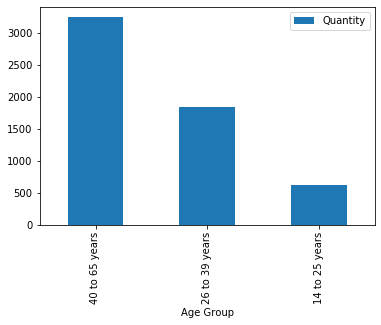

In [54]:
challenge1a_df.plot(kind='bar',x='Age Group',y='Quantity')
plt.show()

In [55]:
df_proargs.head()

NameError: name 'df_proargs' is not defined

In [56]:
df_proargs=bonus1_df["question: BI arguments for"].str.split(pat = "|",expand=True)
listpro=np.array([df_proargs[0].unique(),df_proargs[1].unique(),df_proargs[2].unique(),df_proargs[3].unique(),df_proargs[4].unique(),df_proargs[5].unique()])
list_proArgs = set([str(item).strip() for sublist in listpro for item in sublist])

NameError: name 'bonus1_df' is not defined

In [51]:
df_consargs=bonus1_df["question: BI arguments against"].str.split(pat = "|",expand=True)
listcons=np.array([df_consargs[0].unique(),df_consargs[1].unique(),df_consargs[2].unique(),df_consargs[3].unique(),df_consargs[4].unique(),df_consargs[5].unique()])
list_consArgs = set([str(item).strip() for sublist in listcons for item in sublist])

NameError: name 'bonus1_df' is not defined

In [52]:
list_proArgs

NameError: name 'list_proArgs' is not defined

In [53]:
list_consArgs

NameError: name 'list_consArgs' is not defined

In [66]:
bonus1_columns = ["question: BI arguments for","question: BI arguments against"]
bonus1_df= df_raw[bonus1_columns]


In [14]:
df_consargs.head()

NameError: name 'df_consargs' is not defined

# ANALISIS EXPLORATORIO

In [ ]:
filer_null_cols = df_career_info.isnull().sum()
filer_null_cols[filer_null_cols > 0] / len(df_career_info)*100
    

In [ ]:
df_career_info['normalized_job_code'].fillna('no_full_time_job',inplace=True)
df_career_info['dem_education_level'].fillna('unknown',inplace=True)

In [ ]:
df_career_info['dem_education_level'].unique()

In [ ]:
df_career_info['normalized_job_code'] = df_career_info['normalized_job_code'].astype("|S")
df_career_info['dem_education_level'] = df_career_info['dem_education_level'].astype('str')
df_career_info['dem_full_time_job'] = df_career_info['dem_full_time_job'].astype("bool") // Yes = TRUE. NO = FALSE //

In [ ]:
df_career_info['dem_full_time_job']

In [ ]:
df_career_info.dtypes

In [ ]:
PERSONAL INFO

In [ ]:
df_personal_info.dtypes

In [ ]:
df_personal_info["age"].unique()

In [ ]:
df_personal_info["gender"].unique()

In [ ]:
df_personal_info["dem_has_children"].unique()

In [ ]:
df_personal_info["age_group"].unique()

In [ ]:
#FIXING VALUES
df_personal_info["gender"].replace(to_replace = ['male','Fem','FeMale','female'], value = ['Male', 'Female','Female','Female'],inplace=True) 
df_personal_info["dem_has_children"].replace(to_replace = ['yES', 'YES','nO','NO'], value = [True, True,False,False],inplace=True) 


In [ ]:
#FIXING DATA TYPES
df_personal_info["dem_has_children"] = df_personal_info["dem_has_children"].astype("bool")

In [ ]:
df_personal_info.dtypes

In [ ]:
df_personal_info_test= df_personal_info["age"]

In [ ]:
df_personal_info_test

In [ ]:
df_personal_info_test.replace('\s\w*\s\w*',"",regex=True, inplace = True)
df_personal_info_test.apply(lambda x: 2016-int(x) if len(x)>2 else x)

In [ ]:
'''
ages = []
for x in df_personal_info_test:
    
    if len(x)>2:
        ages.append(2016-int(x))
''''''


CONECTAR API

In [ ]:
df_jobnames

In [ ]:
df_countries

In [ ]:
'''
df_country_info = pd.read_sql_query("SELECT * FROM country_info", engine)
df_career_info = pd.read_sql_query("SELECT * FROM career_info", engine)
df_personal_info = pd.read_sql_query("SELECT * FROM personal_info", engine)
df_poll_info = pd.read_sql_query("SELECT * FROM poll_info", engine)


In [9]:
import vlc
p = vlc.MediaPlayer("surprise/surprise.mp3")
p.play()

0

In [10]:
p.stop()

In [ ]:
BONUS1






In [ ]:
BONUS 3

In [ ]:
pdfkit.from_file('my_test.html', my_'output.pdf')

In [42]:
import pandas as pd
import pdfkit as pdf
import sqlite3

In [44]:
challenge1_df.head(10).to_html('data/results/challenge1.html')
pdf.from_file('data/results/challenge1.html','data/results/challenge1.pdf')

OSError: No wkhtmltopdf executable found: "b''"
If this file exists please check that this process can read it. Otherwise please install wkhtmltopdf - https://github.com/JazzCore/python-pdfkit/wiki/Installing-wkhtmltopdf

In [2]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
top10=challenge1_df.head(10)

NameError: name 'challenge1_df' is not defined

In [ ]:
fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=top10.values,colLabels=top10.columns,loc='center')

In [54]:
pp = PdfPages("data/results/challenge1.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()